# H&M Personalized Fashion Recommendations: 1. Data preparation

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime

## 1. Data download 

In [2]:
articles = pd.read_csv("../input/articles.csv", dtype={"article_id": str})
customers = pd.read_csv("../input/customers.csv")
transactions = pd.read_csv("../input/transactions.csv", dtype={"article_id": str})

## 2. Transactions 

In [3]:
print(transactions.shape)
transactions.head(3)

(31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2


In [4]:
transactions["sales_channel_1_flg"] = (transactions["sales_channel_id"] == 1).astype(int)
transactions["sales_channel_2_flg"] = (transactions["sales_channel_id"] == 2).astype(int)
del transactions["sales_channel_id"]

## 3. Articles 

In [5]:
print(articles.shape)
articles.head(3)

(105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [6]:
articles["product_code_name"] = articles[["product_code", "prod_name"]].astype(str).agg(": ".join, axis=1)
articles["department_no_name"] = articles[["department_no", "department_name"]].astype(str).agg(": ".join, axis=1)
articles["section_no_name"] = articles[["section_no", "section_name"]].astype(str).agg(": ".join, axis=1)

articles = articles.drop([
    "product_code", "prod_name", "product_type_no", "graphical_appearance_no", 
    "colour_group_code", "perceived_colour_value_id", "perceived_colour_master_id", 
    "department_no", "department_name", "index_code", "index_group_no", "section_no", 
    "section_name", "garment_group_no"], 
    axis=1
)

articles = articles.fillna({"detail_desc": "Unknown"})

In [7]:
def crop_by_top_values(series, min_value_count):
    series_value_counts = series.value_counts()
    value_list = series_value_counts[series_value_counts > min_value_count].index

    new_series = series.apply(lambda x: x if x in value_list else "Other")
    return new_series

articles["product_code_name"] = crop_by_top_values(articles["product_code_name"], min_value_count = 20)

In [8]:
for col in articles.columns:
    print(col, articles[col].unique().shape[0])

article_id 105542
product_type_name 131
product_group_name 19
graphical_appearance_name 30
colour_group_name 50
perceived_colour_value_name 8
perceived_colour_master_name 20
index_name 10
index_group_name 5
garment_group_name 21
detail_desc 43405
product_code_name 71
department_no_name 299
section_no_name 57


In [9]:
articles_agg = (
    transactions
        .groupby(["article_id"])
        .agg({
            "price": ["min", "max", "mean", "std"],
            "sales_channel_1_flg": ["sum"], 
            "sales_channel_2_flg": ["sum"],
            "t_dat": ["min", "max"]})
)

articles_agg.columns = articles_agg.columns.map(lambda x: "_".join(x))

articles_agg["sales_sum"] = (
    articles_agg["sales_channel_1_flg_sum"] + articles_agg["sales_channel_2_flg_sum"]
)

articles_agg["sales_channel_1_ratio"] = (
    articles_agg["sales_channel_1_flg_sum"] / articles_agg["sales_sum"]
    
)
articles_agg = articles_agg.fillna(0.0)

def day_diff(max_date, min_date):
    date_format = "%Y-%m-%d"
    return (datetime.strptime(max_date, date_format) - 
            datetime.strptime(min_date, date_format)).days

t_dat_max = transactions["t_dat"].max()
articles_agg["last_days_ago"] = articles_agg["t_dat_max"].apply(lambda x: day_diff(t_dat_max, x))
articles_agg["first_days_ago"] = articles_agg["t_dat_min"].apply(lambda x: day_diff(t_dat_max, x))
del articles_agg["t_dat_max"], articles_agg["t_dat_min"]
articles_agg

,price_min,price_max,price_mean,price_std,sales_channel_1_flg_sum,sales_channel_2_flg_sum,sales_sum,sales_channel_1_ratio,last_days_ago,first_days_ago
article_id,,,,,,,,,,
0108775015,0.001339,0.009153,0.008142,0.000652,2485,8356,10841,0.229222,62,733
0108775044,0.001424,0.008508,0.008114,0.000735,2101,5149,7250,0.289793,2,733
0108775051,0.003237,0.008458,0.004980,0.000544,1,214,215,0.004651,452,733
0110065001,0.002525,0.025407,0.020219,0.006844,652,392,1044,0.624521,51,733
0110065002,0.004542,0.025407,0.018205,0.006004,186,353,539,0.345083,48,733
...,...,...,...,...,...,...,...,...,...,...
0952267001,0.010153,0.016932,0.014982,0.002385,25,16,41,0.609756,0,24
0952938001,0.040661,0.050831,0.048006,0.004300,0,9,9,0.000000,0,7
0953450001,0.015305,0.016932,0.016836,0.000395,0,17,17,0.000000,0,15


In [10]:
mean_count = (
    transactions.groupby(["customer_id", "article_id"]).size()
        .groupby(["article_id"]).mean()
        .reset_index().rename({0: "mean_count_on_customer"}, axis=1)
)
mean_count

,article_id,mean_count_on_customer
0,0108775015,1.574582
1,0108775044,1.372067
2,0108775051,1.279762
3,0110065001,1.104762
4,0110065002,1.171739
...,...,...
104542,0952267001,1.205882
104543,0952938001,1.000000
104544,0953450001,1.062500
104545,0953763001,1.521739


In [11]:
articles = (
    articles.merge(articles_agg, on="article_id", how="left")
            .merge(mean_count, on="article_id", how="left")    
            .fillna({"last_days_ago": 9999, "first_days_ago": 9999})
            .fillna(0.0)
)

## 3. Customers 

In [12]:
print(customers.shape)
customers.head(3)

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...


In [13]:
customers = customers.fillna({"FN": 1.0, 
                              "Active": 1.0, 
                              "club_member_status": "Other", 
                              "fashion_news_frequency": "None", 
                              "age": customers["age"].median()})

In [14]:
customers["postal_code"] = crop_by_top_values(customers["postal_code"], min_value_count=30)

In [15]:
for col in customers.columns:
    print(col, customers[col].unique().shape[0])

customer_id 1371980
FN 1
Active 1
club_member_status 4
fashion_news_frequency 4
age 84
postal_code 447


In [16]:
customers["age"].map({})

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
1371975   NaN
1371976   NaN
1371977   NaN
1371978   NaN
1371979   NaN
Name: age, Length: 1371980, dtype: float64

In [17]:
age_median = customers["age"].median()
customers["age"] = customers["age"].apply(lambda x: x if x > 0 else age_median) 

def get_age_group(age):
    if 16 <= age < 22:
        return "16-21"
    elif 22 <= age < 30:
        return "22-29"
    elif 30 <= age < 45:
        return "30-44"
    elif 45 <= age < 55:
        return "45-54"
    else:
        return "54+"

customers["age_group"] = customers["age"].apply(get_age_group)

In [18]:
customer_agg = (
    transactions
        .groupby(["customer_id"])
        .agg({
            "price": ["min", "max", "mean", "std"],
            "sales_channel_1_flg": ["sum"], 
            "sales_channel_2_flg": ["sum"],
            "t_dat": ["min", "max"]})
)

customer_agg.columns = customer_agg.columns.map(lambda x: "_".join(x))

customer_agg["sales_sum"] = (
    customer_agg["sales_channel_1_flg_sum"] + customer_agg["sales_channel_2_flg_sum"]
)

customer_agg["sales_channel_1_ratio"] = (
    customer_agg["sales_channel_1_flg_sum"] / customer_agg["sales_sum"]
)

def day_diff(max_date, min_date):
    date_format = "%Y-%m-%d"
    return (datetime.strptime(max_date, date_format) - 
            datetime.strptime(min_date, date_format)).days

t_data_max = transactions["t_dat"].max()
customer_agg["last_days_ago"] = customer_agg["t_dat_max"].apply(lambda x: day_diff(t_data_max, x))
customer_agg["first_days_ago"] = customer_agg["t_dat_min"].apply(lambda x: day_diff(t_data_max, x))
del customer_agg["t_dat_max"], customer_agg["t_dat_min"]

customer_agg = customer_agg.fillna(0.0)
customer_agg

,price_min,price_max,price_mean,price_std,sales_channel_1_flg_sum,sales_channel_2_flg_sum,sales_sum,sales_channel_1_ratio,last_days_ago,first_days_ago
customer_id,,,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0.010153,0.054220,0.030904,0.015718,9,12,21,0.428571,17,635
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,0.006763,0.084729,0.030255,0.016957,5,81,86,0.058140,76,732
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0.013542,0.067780,0.039154,0.016858,0,18,18,0.000000,7,733
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0.030492,0.030492,0.030492,0.000000,0,2,2,0.000000,471,471
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0.016932,0.059305,0.036130,0.012638,2,11,13,0.153846,41,711
...,...,...,...,...,...,...,...,...,...,...
ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831,0.005068,0.067780,0.025340,0.011733,13,38,51,0.254902,16,538
ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53481233731b5c4f8b7,0.005068,0.076254,0.021516,0.013751,28,56,84,0.333333,35,728
ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264,0.004559,0.042356,0.017532,0.009565,11,34,45,0.244444,13,733


In [19]:
mean_count = (
    transactions.groupby(["customer_id", "t_dat"]).size()
        .groupby(["customer_id"]).mean()
        .reset_index().rename({0: "mean_article_count_on_date"}, axis=1)
)

In [20]:
tr_articles = transactions.merge(articles, on="article_id", how="inner")

groups = None
for group in articles["index_group_name"].unique():
    group_df = (
        tr_articles[tr_articles["index_group_name"] == group]
            .groupby(["customer_id"]).size()
            .reset_index().rename({0: f"{group}_count"}, axis=1)
    )
    if groups is not None:
        groups = groups.merge(group_df, on="customer_id", how="outer") 
    else:
        groups = group_df

In [21]:
customers = (
    customers.merge(customer_agg, on="customer_id", how="left")
            .merge(mean_count, on="customer_id", how="left")
            .merge(groups, on="customer_id", how="left")
            .fillna({"last_days_ago": 9999, "first_days_ago": 9999})
            .fillna(0.0)
)

In [22]:
def get_common_group(line):
    counter = [
        (line["Ladieswear_count"], "Lady"),
        (line["Baby/Children_count"], "Children"),
        (line["Divided_count"] + line["Sport_count"], "Divided"),
        (line["Menswear_count"], "Men")
    ]
    
    return list(map(lambda x: x[1], sorted(counter, key=lambda x: -x[0])))[0]
customers["common_group"] = customers.apply(get_common_group, axis=1)

In [23]:
def get_sex(line):
    sex_factor = line["Menswear_count"] - line["Ladieswear_count"]
    if sex_factor > 0:
        return "Men"
    elif sex_factor < 0:
        return "Woman"
    else:
        return "Unknown"
customers["sex"] = customers.apply(get_sex, axis=1) 

In [24]:
customers["has_children"] = customers.apply(lambda x: int(x["Baby/Children_count"] > 0), axis=1) 

In [73]:
prices = sorted(customers["price_max"].to_list())
q1 = len(prices) // 4
q3 = q1 * 3

def get_price_group(price_mean):
    if price_mean < prices[q1]:
        return "low"
    elif price_mean < prices[q3]:
        return "medium"
    else:
        return "high"
customers["price_group"] = customers["price_max"].apply(get_price_group)

In [70]:
customers["price_group"].value_counts()

medium    647013
high      414338
low       310629
Name: price_group, dtype: int64

<AxesSubplot:xlabel='t_dat'>

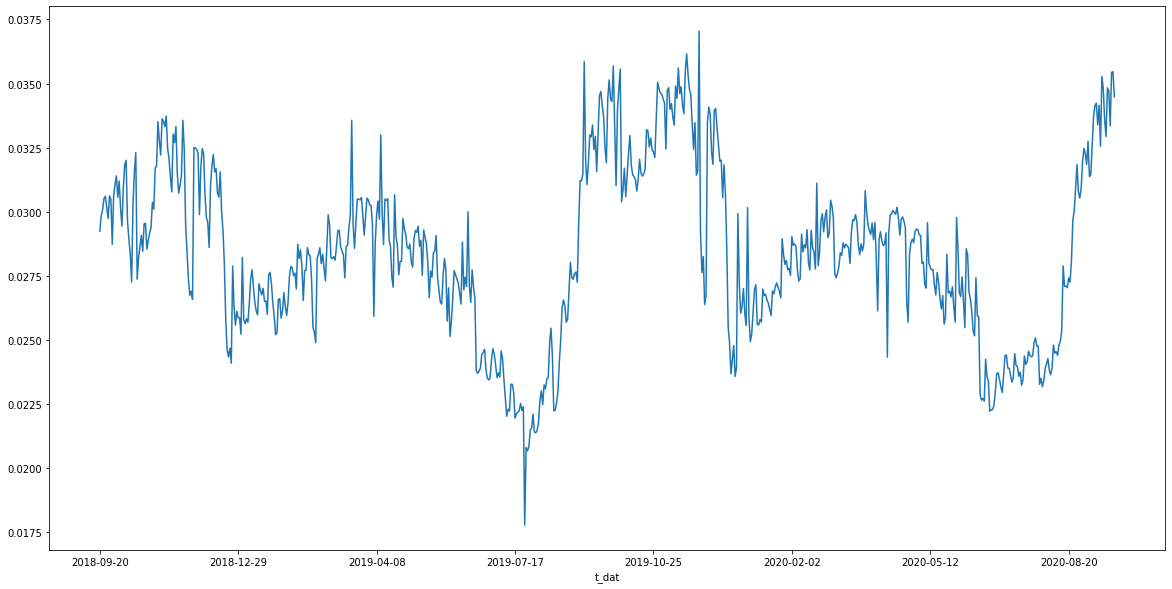

In [71]:
plt.figure(figsize=(20, 10))
transactions.groupby("t_dat")["price"].mean().plot()

## 5. Index transformation 

In [62]:
# customers = (
#     customers.reset_index()
#             .rename({"customer_id": "customer_id_raw", 
#                      "index": "customer_id"}, axis=1)
# )

# articles = (
#     articles.reset_index()
#             .rename({"article_id": "article_id_raw",
#                      "index": "article_id"}, axis=1)
# )

In [63]:
# transactions = (
#     transactions.rename({"customer_id": "customer_id_raw",
#                          "article_id": "article_id_raw"}, axis=1)
#         .merge(customers[["customer_id", "customer_id_raw"]], on="customer_id_raw", how="inner")
#         .merge(articles[["article_id", "article_id_raw"]], on="article_id_raw", how="inner")
# )
# transactions

## 6. Data save 

In [72]:
articles.to_csv("../input/articles_proc.csv", header=True, index=False)
customers.to_csv("../input/customers_proc.csv", header=True, index=False)
# transactions_train.to_csv("../input/transactions_train.csv", header=True, index=False)
# transactions_test.to_csv("../input/transactions_test.csv", header=True, index=False)
transactions.to_csv("../input/transactions_full.csv", header=True, index=False)